Concat data and import libraries.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import collections
import catboost as cb


# Other Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, precision_recall_curve
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")

file_path = "./bbd-payments-hackathon-2025/Payments Fraud DataSet/"


In [96]:
terminal_stats = None
knn= None
fraud_locations = None

def process_data_for_training(targetFile = 'transactions_train.csv', isTest = False):
    global terminal_stats
    global knn
    global fraud_locations

    # Join the files

    customers_df = pd.read_csv(file_path + "customers.csv")
    merchants_df = pd.read_csv(file_path + "merchants.csv")
    terminals_df = pd.read_csv(file_path + "terminals.csv")
    transactions_df = pd.read_csv(file_path + targetFile)

    merged_train = transactions_df.copy()
    merged_train = merged_train.merge(customers_df, on='CUSTOMER_ID', how='left')
    merged_train = merged_train.merge(terminals_df, on='TERMINAL_ID', how='left')
    merged_train = merged_train.merge(merchants_df, on='MERCHANT_ID', how='left')

    merged_train.columns = merged_train.columns.str.upper()

    

    # Time-based Features

    def categorise_transaction_frequency(seconds):
        if pd.isna(seconds):
            return "first"
        elif seconds < 60:
            return "under_1_min"
        elif seconds < 3600:
            return "under_1_hour"
        elif seconds < 86400:
            return "under_1_day"
        elif seconds < 604800:
            return "under_1_week"
        elif seconds < 2.592e+6:
            return "under_1_month"
        elif seconds < 1.555e+7:
            return "under_6_months"
        else:
            return "over_6_months"

    def categorise_time_until_expiration(months):
        if months <= 0:
            return "expired"
        elif months < 1:
            return "under_1_month"
        elif months < 3:
            return "under_3_months"
        elif months < 6:
            return "under_6_months"
        elif months < 12:
            return "under_1_year"
        else:
            return "over_1_year"

    def months_until_expiry(row):
        return (row["CARD_EXPIRY_DATE"].year - row["TX_TS"].year) * 12 + \
            (row["CARD_EXPIRY_DATE"].month - row["TX_TS"].month)
    #NEW
    
    merged_train['original_index'] = merged_train.index

    merged_train["TX_TS"] = pd.to_datetime(merged_train["TX_TS"])
    merged_train["DAY_OF_WEEK"] = merged_train['TX_TS'].dt.day_of_week
    merged_train["HOUR"] = merged_train['TX_TS'].dt.hour
    merged_train["IS_WEEKEND"] = merged_train['TX_TS'].dt.day_of_week >= 5
    merged_train["DAY_OF_MONTH"] = merged_train['TX_TS'].dt.day.astype("category")
    merged_train['WEEK_PERIOD'] = pd.cut(merged_train['DAY_OF_MONTH'], bins=[0, 7, 14, 21, 31], labels=['early', 'mid_early', 'mid_late', 'late'])
    merged_train_sorted = merged_train.sort_values(["CUSTOMER_ID", "TX_TS"])
    merged_train["TIME_SINCE_LAST_TRANSACTION"] = merged_train_sorted.groupby("CUSTOMER_ID")["TX_TS"].diff().dt.total_seconds()
    #Maybe add a feature to check fast transaction attempts
    merged_train["IS_FIRST_TRANSACTION"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].isna().astype(int)
    merged_train["TIME_SINCE_LAST_TRANSACTION"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].fillna(0)
    # merged_train["WINDOW_AFTER_LAST_TRANSACTION_CATEGORY"] = merged_train["TIME_SINCE_LAST_TRANSACTION"].apply(categorise_transaction_frequency).astype("category")
    merged_train["IS_BUSINESS_HOURS"] = (merged_train["TX_TS"].dt.hour >=8) | (merged_train["TX_TS"].dt.hour <=17)
    merged_train["CARD_EXPIRY_DATE"] = pd.to_datetime(
        "01/" + merged_train["CARD_EXPIRY_DATE"].astype(str), format="%d/%m/%y"
    )
    merged_train["CARD_EXPIRY_DATE"] = merged_train["CARD_EXPIRY_DATE"].dt.to_period('M').dt.end_time
    merged_train["MONTHS_UNTIL_EXPIRY"] = merged_train.apply(months_until_expiry, axis=1)
    merged_train["EXPIRY_CATEGORY"] = merged_train["MONTHS_UNTIL_EXPIRY"].apply(categorise_time_until_expiration).astype("category")

    #NEW
    merged_train_sorted = merged_train.sort_values(by=['CUSTOMER_ID', 'TX_TS'])
    customer_avg_amount = merged_train.groupby('CUSTOMER_ID')['TX_AMOUNT'].mean().reset_index()
    customer_avg_amount.rename(columns={'TX_AMOUNT': 'CUSTOMER_AVERAGE_AMOUNT'}, inplace=True)
    merged_train = merged_train.merge(customer_avg_amount, on='CUSTOMER_ID', how='left')

    merged_train = merged_train.sort_values(by='original_index').drop(columns=['original_index'])

    # Interaction Feature
    merged_train['TX_AMOUNT_BY_CUSTOMER_CARD'] = merged_train['TX_AMOUNT'] / merged_train['CUSTOMER_AVERAGE_AMOUNT']
    merged_train.fillna({'TX_AMOUNT_BY_CUSTOMER_CARD': 0}, inplace=True)
    merged_train['TX_AMOUNT_BY_CUSTOMER_AVG'] = merged_train['TX_AMOUNT'] / merged_train['CUSTOMER_AVERAGE_AMOUNT']
    merged_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_train.fillna({'TX_AMOUNT_BY_CUSTOMER_AVG': 0}, inplace=True)

    print(f"Min value: {merged_train['TIME_SINCE_LAST_TRANSACTION'].min()}")
    print(f"Max value: {merged_train['TIME_SINCE_LAST_TRANSACTION'].max()}")
    print(f"Values equal to 0: {(merged_train['TIME_SINCE_LAST_TRANSACTION'] == 0).sum()}")

    merged_train['IS_IMMEDIATE_REPEAT'] = (merged_train['TIME_SINCE_LAST_TRANSACTION'] < 300)  # < 5 minutes
    merged_train['IS_DORMANT_REACTIVATION'] = (merged_train['TIME_SINCE_LAST_TRANSACTION'] > 86400 * 30)  # > 30 days
    merged_train['TIME_CATEGORY'] = pd.cut(
        merged_train['TIME_SINCE_LAST_TRANSACTION'], 
        bins=[0, 300, 3600, 86400, 604800, float('inf')],
        include_lowest=True,
        labels=['immediate', 'under_1h', 'under_1d', 'under_1w', 'over_1w']
    )

    # Geographical Features

    # If we are training our model, we get the geographical information of our dataset.
    # 1. NEAREST_FRAUD_DISTANCE
    # 2. FRAUD_DENSITY_1KM
    # 3. FRAUD_DENSITY_5KM
    # 4. KNN_FRAUD_RISK_SCORE
    # 5. AVG_3_NEAREST_FRAUDS
    # 6. FRAUD_HOTSPOT_CATEGORY

    if not isTest:
        fraud_locations = merged_train[merged_train['TX_FRAUD'] == 1][['X_CUSTOMER_ID', 'Y_CUSTOMER_ID']].values
        merged_train = create_comprehensive_knn_features(merged_train, fraud_locations, is_training=True)
    else:
        merged_train = create_comprehensive_knn_features(merged_train, fraud_locations, is_training=False)

    coord_cols = merged_train[['X_TERMINAL_ID', 'Y_TERMINAL_ID','X_CUSTOMER_ID','Y_CUSTOMER_ID']]

    
    # Find customer and terminal coordinates
    customer_coords = merged_train[['X_CUSTOMER_ID','Y_CUSTOMER_ID']]
    terminal_coords = merged_train[['X_TERMINAL_ID', 'Y_TERMINAL_ID']]

    if len(customer_coords) >= 2 and len(terminal_coords) >= 2:

        # Distance calculations
        merged_train['EUCLIDEAN_DISTANCE'] = np.sqrt(
            (merged_train['X_CUSTOMER_ID'] - merged_train['X_TERMINAL_ID'])**2 +
            (merged_train['Y_CUSTOMER_ID'] - merged_train['Y_TERMINAL_ID'])**2
        )

        merged_train['MANHATTAN_DISTANCE'] = (
            abs(merged_train['X_CUSTOMER_ID'] - merged_train['X_TERMINAL_ID']) +
            abs(merged_train['Y_CUSTOMER_ID'] - merged_train['Y_TERMINAL_ID'])
        )

        # Distance categories
        merged_train['DISTANCE_CATEGORY'] = pd.cut(merged_train['EUCLIDEAN_DISTANCE'],
                                            bins=[0, 10, 25, 50, 100, float('inf')],
                                            labels=['very_close', 'close', 'medium', 'far', 'very_far'])
        merged_train['DISTANCE_CATEGORY'] = merged_train['DISTANCE_CATEGORY'].fillna('medium')

# We get terminal aggregate features since we noticed that terminal location is a big indicator of fraud
    if (isTest == False):
        terminal_stats = (
            merged_train.groupby("TERMINAL_ID")["TX_FRAUD"]
            .agg(["mean", "sum", "count"])
            .reset_index()
            .rename(columns={
                "mean": "TERMINAL_FRAUD_RATE",
                "sum": "TERMINAL_FRAUD_COUNT",
                "count": "TERMINAL_TX_COUNT"
            })
        )

        merged_train = merged_train.merge(terminal_stats, on="TERMINAL_ID", how="left")
    else:
        # Use precomputed stats (must exist already)
        if terminal_stats is None:
            raise ValueError("terminal_stats not initialized. Run on training data first.")

        merged_train = merged_train.merge(terminal_stats, on="TERMINAL_ID", how="left")

        # Fill missing values for unseen terminals
        merged_train.fillna({
            "TERMINAL_FRAUD_RATE": 0,  # or global fraud rate
            "TERMINAL_FRAUD_COUNT": 0,
            "TERMINAL_TX_COUNT": 0
        }, inplace=True)
    
    merged_train['FRAUD_RISK_ZONE'] = pd.Categorical(
        np.where(merged_train['NEAREST_FRAUD_DISTANCE'] < 1.0, 'high_risk',
                np.where(merged_train['NEAREST_FRAUD_DISTANCE'] < 5.0, 'medium_risk', 'low_risk')),
        categories=['low_risk', 'medium_risk', 'high_risk'],
        ordered=True
        )
    merged_train['TERMINAL_CUSTOMER_DISTANCE_RANK'] = merged_train.groupby('TERMINAL_ID')['EUCLIDEAN_DISTANCE'].rank(pct=True)

    merged_train['FAILURE_REASON'] = merged_train['FAILURE_REASON'].fillna("Approved or completed successfully")

    merged_train['DISTANCE_X_TERMINAL_RATE'] = merged_train['NEAREST_FRAUD_DISTANCE'] * merged_train['TERMINAL_FRAUD_RATE']
    merged_train['TIME_X_DISTANCE'] = merged_train['TIME_SINCE_LAST_TRANSACTION'] * merged_train['NEAREST_FRAUD_DISTANCE']

    # We do some dropping of columns and conversions to category for LightGBM
    drop_cols = []
    if (isTest):
        drop_cols = [
            'CARD_DATA',
            'TX_TS',
            'CARD_EXPIRY_DATE',
            'ACQUIRER_ID',
            'LEGAL_NAME',
            'TRANSACTION_GOODS_AND_SERVICES_AMOUNT',
            'TRANSACTION_CASHBACK_AMOUNT',
            'CARD_BRAND',
            'FAILURE_CODE',
            'TAX_FREE_INDICATOR',
            'MCC_CODE',
            'MERCHANT_ID',
            'TRANSACTION_TYPE',
            'CARDHOLDER_AUTH_METHOD',
            'CUSTOMER_ID',
            'X_CUSTOMER_ID',
            'Y_CUSTOMER_ID',
            'MERCHANT_ID',
            'Y_TERMINAL_ID',
            'X_TERMINAL_ID',
        ]
    else:
        drop_cols = [
            'TX_ID',
            'CARD_DATA',
            'TX_TS',
            'CARD_EXPIRY_DATE',
            'ACQUIRER_ID',
            'LEGAL_NAME',
            'TRANSACTION_GOODS_AND_SERVICES_AMOUNT',
            'TRANSACTION_CASHBACK_AMOUNT',
            'CARD_BRAND',
            'FAILURE_CODE',
            'TAX_FREE_INDICATOR',
            'MCC_CODE',
            'MERCHANT_ID',
            'TRANSACTION_TYPE',
            'CARDHOLDER_AUTH_METHOD',
            'CUSTOMER_ID',
            'X_CUSTOMER_ID',
            'Y_CUSTOMER_ID',
            'MERCHANT_ID',
            'Y_TERMINAL_ID',
            'X_TERMINAL_ID',

        ]
    merged_train = merged_train.drop(columns=drop_cols, errors='ignore')

    categorical_cols = [
        'CARD_BRAND', 'TRANSACTION_STATUS',
        'FAILURE_CODE', 'BUSINESS_TYPE', 'OUTLET_TYPE',
        'EXPIRY_CATEGORY', 'DISTANCE_CATEGORY', 'CARD_COUNTRY_CODE', 'IS_RECURRING_TRANSACTION', 'TRANSACTION_CURRENCY' ,'FAILURE_REASON','TAX_EXCEMPT_INDICATOR'
    ]

    for col in categorical_cols:
        if col in merged_train.columns:
            merged_train[col] = merged_train[col].astype('category')

    bool_cols = merged_train.select_dtypes(include='bool').columns
    merged_train[bool_cols] = merged_train[bool_cols].astype(int)

    for date_col in ['FOUNDATION_DATE', 'ACTIVE_FROM', 'TRADING_FROM']:
        if date_col in merged_train.columns:
            merged_train[date_col] = pd.to_datetime(merged_train[date_col], errors='coerce')
            merged_train[f'{date_col}_AGE_DAYS'] = (pd.to_datetime('2021-12-07') - merged_train[date_col]).dt.days
            merged_train = merged_train.drop(columns=[date_col])
    print("Final feature set:")
    print(merged_train.dtypes)
    print("Number of features:", merged_train.shape[1])

    print(merged_train.isna().sum())

    return merged_train

def create_comprehensive_knn_features(df, fraud_coords, is_training=True):
    """
    Create comprehensive KNN-based fraud hotspot features
    """
    if len(fraud_coords) < 3:  # Need minimum fraud points
        df['NEAREST_FRAUD_DISTANCE'] = 999.0  # Large default value
        df['FRAUD_DENSITY_1KM'] = 0
        df['FRAUD_DENSITY_5KM'] = 0
        df['KNN_FRAUD_RISK_SCORE'] = 0.0
        return df
    
    all_coords = df[['X_CUSTOMER_ID', 'Y_CUSTOMER_ID']].values
    
    # Multiple KNN models for different scales
    knn_close = NearestNeighbors(n_neighbors=min(3, len(fraud_coords)), metric='euclidean')
    knn_radius_1km = NearestNeighbors(radius=1.0, metric='euclidean')  # Adjust radius as needed
    knn_radius_5km = NearestNeighbors(radius=5.0, metric='euclidean')
    
    knn_close.fit(fraud_coords)
    knn_radius_1km.fit(fraud_coords) 
    knn_radius_5km.fit(fraud_coords)
    
    # Distance to nearest frauds
    distances, _ = knn_close.kneighbors(all_coords)
    df['NEAREST_FRAUD_DISTANCE'] = distances[:, 0]  # Closest fraud
    df['AVG_3_NEAREST_FRAUDS'] = distances.mean(axis=1)
    
    # Fraud density features
    distances_1km, indices_1km = knn_radius_1km.radius_neighbors(all_coords)
    distances_5km, indices_5km = knn_radius_5km.radius_neighbors(all_coords)
    
    df['FRAUD_DENSITY_1KM'] = [len(idx) for idx in indices_1km]
    df['FRAUD_DENSITY_5KM'] = [len(idx) for idx in indices_5km] 
    
    # Fraud hotspot categories
    distance_percentiles = np.percentile(df['NEAREST_FRAUD_DISTANCE'], [25, 50, 75, 90])
    df['FRAUD_HOTSPOT_CATEGORY'] = pd.cut(
        df['NEAREST_FRAUD_DISTANCE'],
        bins=[0] + distance_percentiles.tolist() + [float('inf')],
        labels=['extreme_risk', 'high_risk', 'medium_risk', 'low_risk', 'very_low_risk']
    )
    df['FRAUD_HOTSPOT_CATEGORY'] = df['FRAUD_HOTSPOT_CATEGORY'].fillna('low_risk')
    
    return df

In [97]:
merged_train = process_data_for_training("transactions_train.csv", False)
print(merged_train.head)
merged_test = process_data_for_training("transactions_test.csv", True)
print(merged_test.head)

Min value: 0.0
Max value: 28319991.0
Values equal to 0: 48907
Final feature set:
TERMINAL_ID                              int64
TX_AMOUNT                              float64
TX_FRAUD                                 int64
TRANSACTION_STATUS                    category
FAILURE_REASON                        category
TRANSACTION_CURRENCY                  category
CARD_COUNTRY_CODE                     category
IS_RECURRING_TRANSACTION              category
BUSINESS_TYPE                         category
TAX_EXCEMPT_INDICATOR                 category
OUTLET_TYPE                           category
ANNUAL_TURNOVER_CARD                     int64
ANNUAL_TURNOVER                          int64
AVERAGE_TICKET_SALE_AMOUNT               int64
PAYMENT_PERCENTAGE_FACE_TO_FACE          int64
PAYMENT_PERCENTAGE_ECOM                  int64
PAYMENT_PERCENTAGE_MOTO                  int64
DEPOSIT_REQUIRED_PERCENTAGE              int64
DEPOSIT_PERCENTAGE                       int64
DELIVERY_SAME_DAYS_PERCENT

Stratified training and validation 

In [98]:
def apply_light_smote( X, y, sampling_strategy=0.1):
        print(f"Original class distribution: {Counter(y)}")
        
        # Light SMOTE - only bring fraud rate from 2% to 10%
        smote = SMOTE(
            sampling_strategy=sampling_strategy,
            random_state=42,
            k_neighbors=5
        )
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        print(f"After light SMOTE: {Counter(y_resampled)}")
        return X_resampled, y_resampled


In [99]:
base_models={}
calibrated_models={}
ensemble_model=None
feature_names=None

In [100]:
def create_base_models():
    global base_models
    
    """Create base models optimized for ROC AUC"""
    
    # LightGBM - optimized for ranking/AUC
    lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
        'n_estimators': 1000,
        'scale_pos_weight': 49  
    }
    
    # XGBoost - optimized for probability calibration
    # xgb_params = {
    #     'tree_method':"hist",       # required
    #     'enable_categorical':True,
    #     'objective': 'binary:logistic',
    #     'eval_metric': 'auc',
    #     'learning_rate': 0.05,
    #     'max_depth': 6,
    #     'subsample': 0.8,
    #     'colsample_bytree': 0.8,
    #     'random_state': 42,
    #     'n_estimators': 1000,
    #     'scale_pos_weight': 49,
    # }

    # cb_params = {
    #     'iterations': 1000,
    #     'learning_rate': 0.05,
    #     'depth': 6,
    #     'loss_function': 'Logloss',
    #     'eval_metric': 'AUC',
    #     'random_seed': 42,
    #     'class_weights': [1, 2],
    #     'verbose': False
    # }

    
    base_models = {
        'lgb': lgb.LGBMClassifier(**lgb_params),
        # 'xgb': xgb.XGBClassifier(**xgb_params),
        # 'catboost': cb.CatBoostClassifier(**cb_params)
    }
    
    return base_models

In [101]:
def stratified_cross_validation( X, y, n_splits=5):
    """Perform stratified cross-validation optimized for ROC AUC"""
    
    global base_models
    global calibrated_models
    global ensemble_model
    global feature_names

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    cv_scores = {model_name: [] for model_name in base_models.keys()}
    cv_scores['ensemble'] = []
    
    fold_predictions = {model_name: np.zeros(len(X)) for model_name in base_models.keys()}
    
    print("Starting Stratified Cross-Validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== FOLD {fold} ===")
        
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Apply light SMOTE only to training data
        # X_train_smote, y_train_smote = apply_light_smote(X_train, y_train)
        
        fold_predictions_proba = {}
        
        # Train each base model
        for model_name, model in base_models.items():
            print(f"\nTraining {model_name}...")
            
            if model_name == 'lgb':
                # LightGBM with correct early stopping syntax
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_names=['valid'],
                    eval_metric='auc'
                )
            elif model_name == 'xgb':
                # XGBoost early stopping
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
            # elif model_name == 'catboost':
            #     # CatBoost with native categorical handling
            #     cat_features = list(X_train.select_dtypes(include=['category', 'object']).columns)
            #     model.fit(
            #         X_train, y_train,
            #         cat_features=cat_features,  # Specify categorical features
            #         eval_set=(X_val, y_val),    # Note: tuple not list for CatBoost
            #         verbose=False,
            #         plot=False
            #     )

            
            # Get probability predictions
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calculate ROC AUC
            auc_score = roc_auc_score(y_val, y_pred_proba)
            cv_scores[model_name].append(auc_score)
            
            # Store predictions for ensemble
            fold_predictions[model_name][val_idx] = y_pred_proba
            fold_predictions_proba[model_name] = y_pred_proba
            
            print(f"{model_name} ROC AUC: {auc_score:.4f}")
        
        # Ensemble prediction (simple average)
        ensemble_pred = np.mean(list(fold_predictions_proba.values()), axis=0)
        ensemble_auc = roc_auc_score(y_val, ensemble_pred)
        cv_scores['ensemble'].append(ensemble_auc)
        
        print(f"Ensemble ROC AUC: {ensemble_auc:.4f}")
    
    # Print CV results
    print("\n=== CROSS-VALIDATION RESULTS ===")
    for model_name, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{model_name}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_scores, fold_predictions

In [102]:
def fit_calibrated_models(X, y):
    global base_models
    global calibrated_models
    global ensemble_model
    global feature_names
    """Fit models with probability calibration"""
    print("\n=== FITTING CALIBRATED MODELS ===")
    
    # Apply light SMOTE to full training data
    # X_smote, y_smote = apply_light_smote(X, y)
    
    # Train and calibrate each model
    for model_name, model in base_models.items():
        print(f"\nFitting and calibrating {model_name}...")
        
        # Use CalibratedClassifierCV for probability calibration
        calibrated_model = CalibratedClassifierCV(
            estimator=model,
            method='isotonic',  # Better for large datasets
            cv=3  # 3-fold for calibration
        )
        
        calibrated_model.fit(X, y)
        calibrated_models[model_name] = calibrated_model
        
    # Create ensemble using voting classifier with calibrated models
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in calibrated_models.items()],
        voting='soft'  # Use probability averaging
    )
    
    print("\nFitting ensemble model...")
    ensemble.fit(X, y)
    ensemble_model = ensemble
    
    return

In [103]:
def predict_proba(X):
    """Get ensemble probability predictions"""
    global base_models
    global calibrated_models
    global ensemble_model
    global feature_names
    if ensemble_model is None:
        raise ValueError("Model not fitted. Call fit_calibrated_models first.")
    
    return ensemble_model.predict_proba(X)[:, 1], calibrated_models['lgb'].predict_proba(X)[:,1]

In [104]:
def evaluate_model( X_test, y_test):
        """Comprehensive evaluation focused on ROC AUC"""
        global base_models
        global calibrated_models
        global ensemble_model
        global feature_names
        predictions = predict_proba(X_test)
        
        # ROC AUC
        auc_score = roc_auc_score(y_test, predictions)
        
        # Get ROC curve data
        fpr, tpr, thresholds = roc_curve(y_test, predictions)
        
        # Precision-Recall curve
        precision, recall, pr_thresholds = precision_recall_curve(y_test, predictions)
        
        # Results summary
        print("\n=== MODEL EVALUATION ===")
        print(f"ROC AUC Score: {auc_score:.4f}")
        
        # Different threshold evaluations
        for threshold in [0.1, 0.2, 0.3, 0.5]:
            y_pred = (predictions >= threshold).astype(int)
            precision_score_thresh = precision_score(y_test, y_pred)
            recall_score_thresh = recall_score(y_test, y_pred)
            f1_score_thresh = f1_score(y_test, y_pred)
            
            print(f"\nThreshold {threshold}:")
            print(f"  Precision: {precision_score_thresh:.4f}")
            print(f"  Recall: {recall_score_thresh:.4f}")
            print(f"  F1-Score: {f1_score_thresh:.4f}")
        
        return {
            'auc_score': auc_score,
            'fpr': fpr,
            'tpr': tpr,
            'precision': precision,
            'recall': recall,
            'predictions': predictions
        }

In [105]:
merged_train = process_data_for_training("transactions_train.csv", False)
merged_test = process_data_for_training("transactions_test.csv", True)

# Prepare features and target
X = merged_train.drop(columns=['TX_FRAUD'])
y = merged_train['TX_FRAUD']

print(f"\nDataset shape: {X.shape}")
print(f"Fraud rate: {y.mean():.4f}")

# Initialize detector
create_base_models()

# Perform cross-validation
cv_scores, fold_predictions = stratified_cross_validation(X, y, n_splits=5)

# Fit final calibrated models


Min value: 0.0
Max value: 28319991.0
Values equal to 0: 48907
Final feature set:
TERMINAL_ID                              int64
TX_AMOUNT                              float64
TX_FRAUD                                 int64
TRANSACTION_STATUS                    category
FAILURE_REASON                        category
TRANSACTION_CURRENCY                  category
CARD_COUNTRY_CODE                     category
IS_RECURRING_TRANSACTION              category
BUSINESS_TYPE                         category
TAX_EXCEMPT_INDICATOR                 category
OUTLET_TYPE                           category
ANNUAL_TURNOVER_CARD                     int64
ANNUAL_TURNOVER                          int64
AVERAGE_TICKET_SALE_AMOUNT               int64
PAYMENT_PERCENTAGE_FACE_TO_FACE          int64
PAYMENT_PERCENTAGE_ECOM                  int64
PAYMENT_PERCENTAGE_MOTO                  int64
DEPOSIT_REQUIRED_PERCENTAGE              int64
DEPOSIT_PERCENTAGE                       int64
DELIVERY_SAME_DAYS_PERCENT

In [ ]:
print(merged_test.columns)
print(merged_train.columns)
fit_calibrated_models(X, y)
tx_ids = None
# If you have labels for test set, evaluate
# results = detector.evaluate_model(X_test, y_test)

# Generate predictions for submission
if 'TX_ID' in merged_test.columns:
    test_features = merged_test.drop(columns=['TX_ID', 'ID_JOIN', 'MCC_CODE'], errors='ignore')
    tx_ids = merged_test['TX_ID']
else:
    test_features = merged_test.drop(columns=['ID_JOIN', 'MCC_CODE'], errors='ignore')
    tx_ids = None
print(test_features.columns)
    
# test_predictions_ensemble, xgb_predictions, lgb_predictions = predict_proba(test_features)
test_predictions_ensemble, lgb_predictions = predict_proba(test_features)

from sklearn.metrics import f1_score, classification_report

# Convert probabilities to binary predictions (default threshold = 0.5)
y_pred_binary = (test_predictions_ensemble >= 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_val, y_pred_binary)
print(f"F1 Score (threshold=0.5): {f1:.4f}")

# Create submission file
if tx_ids is not None:
    submission_ensemble = pd.DataFrame({
        'TX_ID': tx_ids,
        'TX_FRAUD': test_predictions_ensemble
    })
    # submission_xgb = pd.DataFrame({
    #     'TX_ID': tx_ids,
    #     'TX_FRAUD': xgb_predictions
    # })
    submission_lgb = pd.DataFrame({
        'TX_ID': tx_ids,
        'TX_FRAUD': lgb_predictions
    })
else:
    print("Something went wrong!!")



submission_ensemble.to_csv('optimised_ensemble.csv', index=False)
# submission_xgb.to_csv('optimised_xgb.csv', index=False)
submission_lgb.to_csv('optimised_lgb.csv', index=False)
print("\nPredictions saved'")

Index(['TX_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TRANSACTION_STATUS',
       'FAILURE_REASON', 'TRANSACTION_CURRENCY', 'CARD_COUNTRY_CODE',
       'IS_RECURRING_TRANSACTION', 'ID_JOIN', 'BUSINESS_TYPE',
       'TAX_EXCEMPT_INDICATOR', 'OUTLET_TYPE', 'ANNUAL_TURNOVER_CARD',
       'ANNUAL_TURNOVER', 'AVERAGE_TICKET_SALE_AMOUNT',
       'PAYMENT_PERCENTAGE_FACE_TO_FACE', 'PAYMENT_PERCENTAGE_ECOM',
       'PAYMENT_PERCENTAGE_MOTO', 'DEPOSIT_REQUIRED_PERCENTAGE',
       'DEPOSIT_PERCENTAGE', 'DELIVERY_SAME_DAYS_PERCENTAGE',
       'DELIVERY_WEEK_ONE_PERCENTAGE', 'DELIVERY_WEEK_TWO_PERCENTAGE',
       'DELIVERY_OVER_TWO_WEEKS_PERCENTAGE', 'DAY_OF_WEEK', 'HOUR',
       'IS_WEEKEND', 'DAY_OF_MONTH', 'WEEK_PERIOD',
       'TIME_SINCE_LAST_TRANSACTION', 'IS_FIRST_TRANSACTION',
       'IS_BUSINESS_HOURS', 'MONTHS_UNTIL_EXPIRY', 'EXPIRY_CATEGORY',
       'CUSTOMER_AVERAGE_AMOUNT', 'TX_AMOUNT_BY_CUSTOMER_CARD',
       'TX_AMOUNT_BY_CUSTOMER_AVG', 'IS_IMMEDIATE_REPEAT',
       'IS_DORMANT_REACTIVATION'

Top 20 Most Important Features:
                            feature  importance
25                     DAY_OF_MONTH        3840
46              TERMINAL_FRAUD_RATE        1441
27      TIME_SINCE_LAST_TRANSACTION        1440
41                FRAUD_DENSITY_5KM        1345
33       TX_AMOUNT_BY_CUSTOMER_CARD        1266
5                 CARD_COUNTRY_CODE        1239
0                       TERMINAL_ID        1120
48                TERMINAL_TX_COUNT        1024
1                         TX_AMOUNT         968
12       AVERAGE_TICKET_SALE_AMOUNT         930
40                FRAUD_DENSITY_1KM         884
32          CUSTOMER_AVERAGE_AMOUNT         847
44               MANHATTAN_DISTANCE         835
4              TRANSACTION_CURRENCY         772
11                  ANNUAL_TURNOVER         744
10             ANNUAL_TURNOVER_CARD         715
50  TERMINAL_CUSTOMER_DISTANCE_RANK         703
30              MONTHS_UNTIL_EXPIRY         694
43               EUCLIDEAN_DISTANCE         671
39      

<Figure size 1000x800 with 0 Axes>

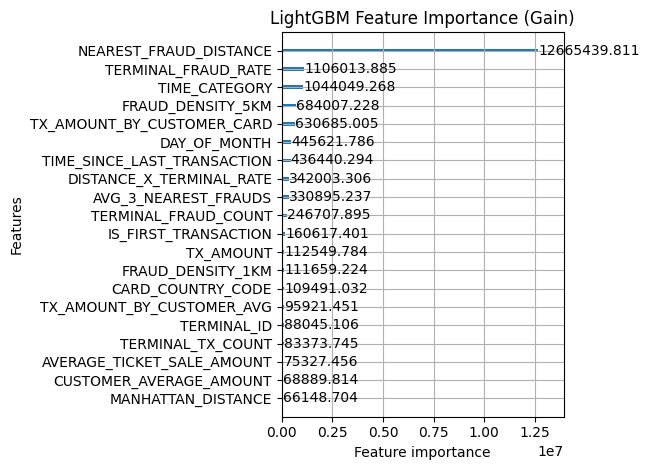

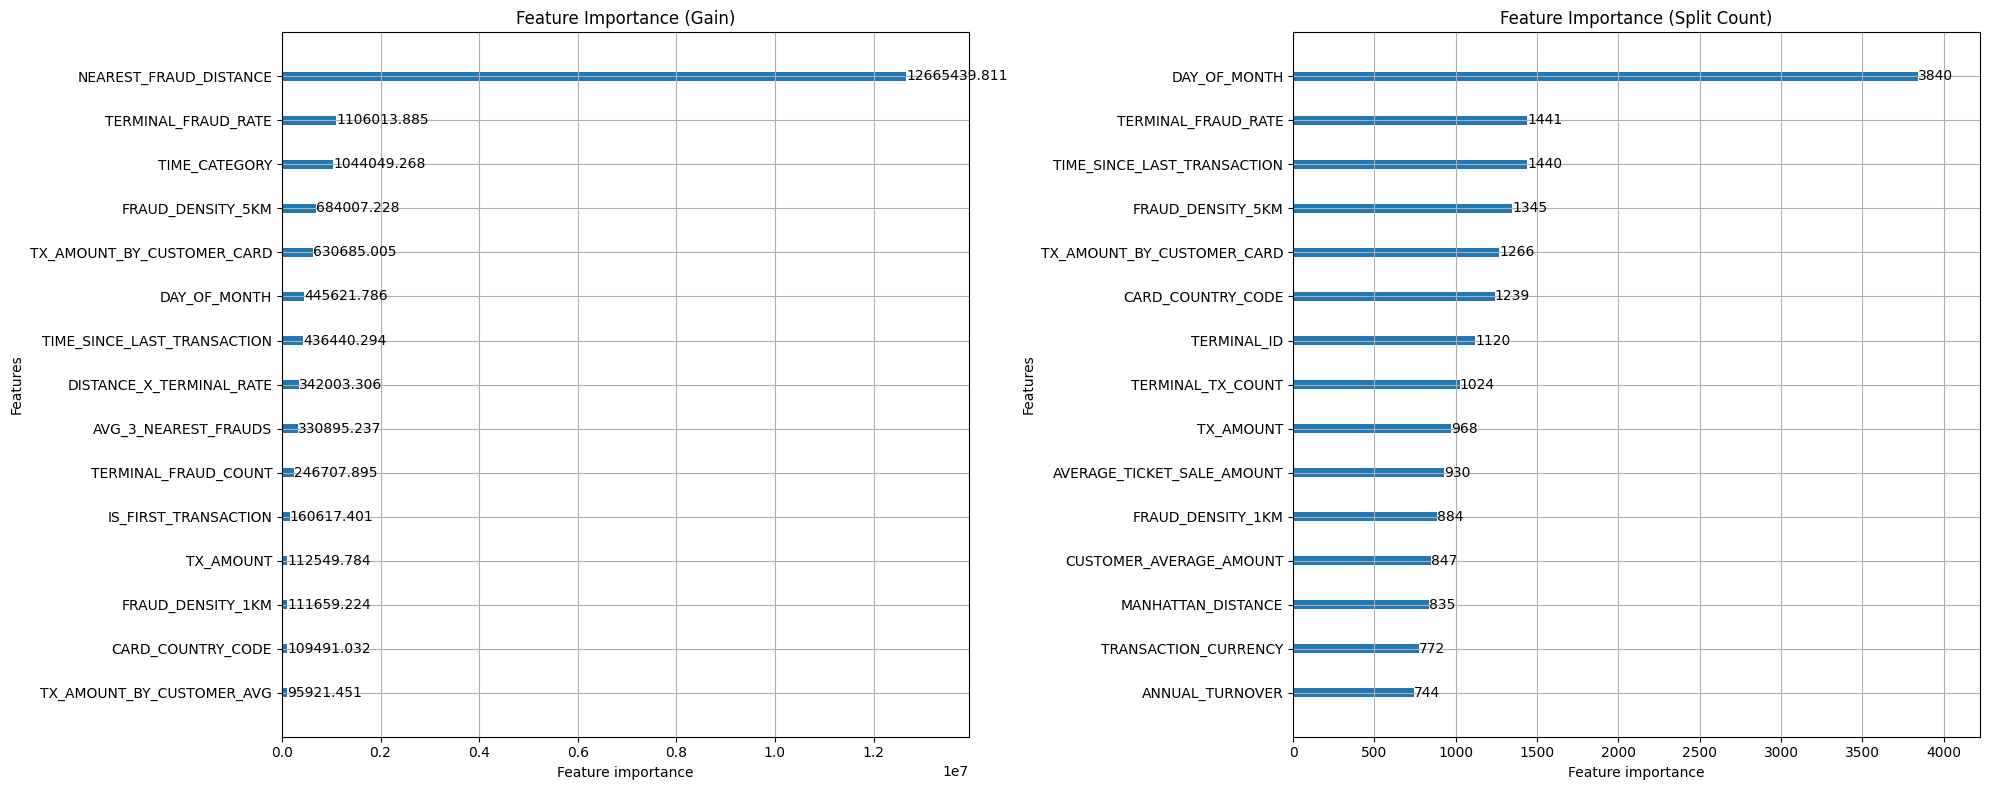

In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb

# Get the trained LightGBM model from your calibrated models
lgb_model = calibrated_models['lgb'].estimator  # Extract base model from calibrated wrapper

# Method 1: Basic feature importance
feature_importance = lgb_model.feature_importances_
feature_names = X.columns  # Your feature names

# Create DataFrame for easier viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

# Method 2: LightGBM's built-in plotting
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title('LightGBM Feature Importance (Gain)')
plt.tight_layout()
plt.show()

# Plot both gain and split importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain', ax=ax1)
ax1.set_title('Feature Importance (Gain)')

lgb.plot_importance(lgb_model, max_num_features=15, importance_type='split', ax=ax2)
ax2.set_title('Feature Importance (Split Count)')

plt.tight_layout()
plt.show()

Calculating SHAP values...
SHAP values calculated!


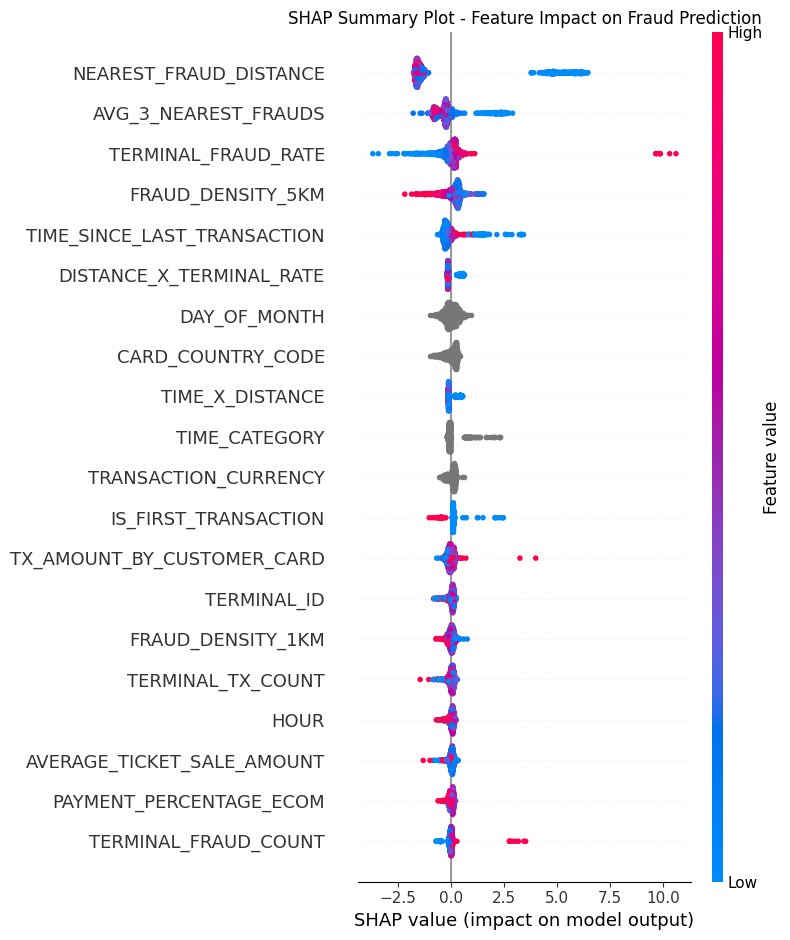

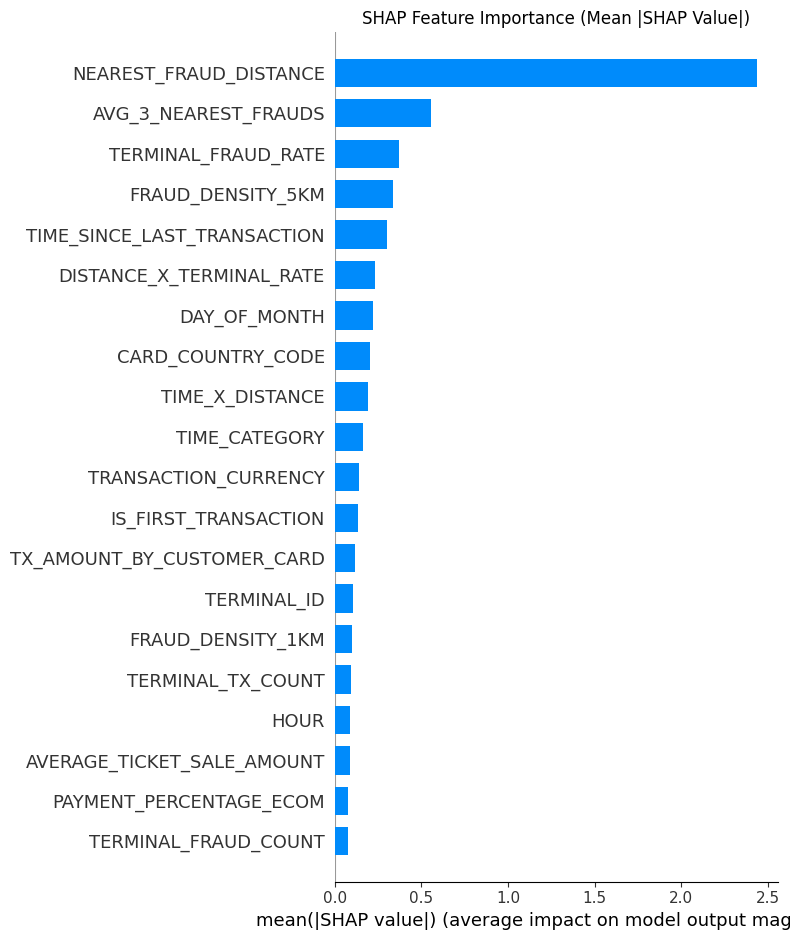

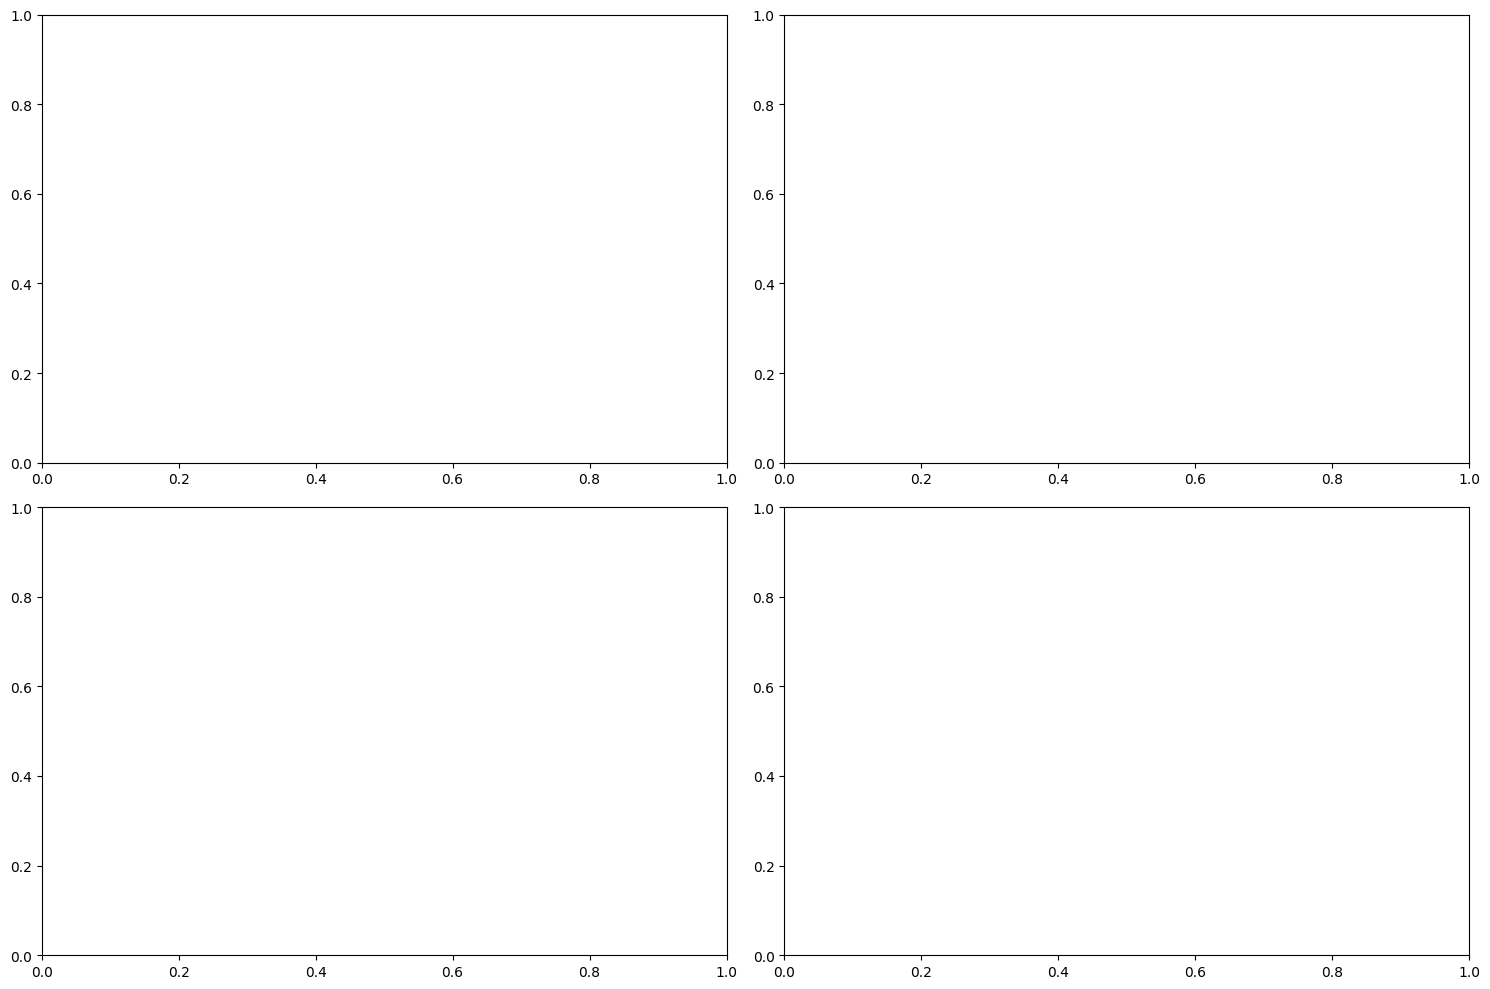

In [108]:
import shap
import numpy as np

# Initialize SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgb_model)

# For large datasets, sample data for SHAP calculations (SHAP can be slow)
sample_size = min(1000, len(X))  # Use 1000 samples or less if dataset is smaller
X_sample = X.sample(n=sample_size, random_state=42)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_sample)

# Use shap_values[1] for positive class (fraud) if binary classification
if isinstance(shap_values, list):
    shap_values_fraud = shap_values[1]  # Fraud class
else:
    shap_values_fraud = shap_values  # Single output

print("SHAP values calculated!")

# 1. Summary Plot (most important visualization)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_fraud, X_sample, max_display=20, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Fraud Prediction')
plt.tight_layout()
plt.show()

# 2. Summary Plot (bar chart version)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_fraud, X_sample, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance (Mean |SHAP Value|)')
plt.tight_layout()
plt.show()

# 3. Waterfall plot for individual prediction
# plt.figure(figsize=(10, 8))
# shap.waterfall_plot(explainer.expected_value[1], shap_values_fraud[0], X_sample.iloc[0])
# plt.title('SHAP Waterfall Plot - Individual Prediction Explanation')
# plt.show()

# 4. Force plot for individual prediction (HTML output)
# shap.force_plot(explainer.expected_value[1], shap_values_fraud[0], X_sample.iloc[0])

# 5. Partial dependence plots for top features
# top_features = importance_df.head(4)['feature'].tolist()  # Top 4 features

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# for i, feature in enumerate(top_features):
#     if feature in X_sample.columns:
#         shap.plots.partial_dependence(
#             feature, lgb_model.predict, X_sample, ice=False,
#             model_expected_value=True, feature_expected_value=True, ax=axes[i]
#         )
#         axes[i].set_title(f'Partial Dependence: {feature}')

plt.tight_layout()
plt.show()

# 6. Feature interaction (for two most important features)
# if len(top_features) >= 2:
#     feature1, feature2 = top_features[0], top_features[1]
#     if feature1 in X_sample.columns and feature2 in X_sample.columns:
#         shap_interaction_values = explainer.shap_interaction_values(X_sample.head(500))  # Smaller sample for interactions
        
#         plt.figure(figsize=(10, 8))
#         shap.summary_plot(
#             shap_interaction_values, X_sample.head(500), 
#             max_display=10, show=False
#         )
#         plt.title('SHAP Interaction Values')
#         plt.tight_layout()
#         plt.show()